## Step1: Data Exploration
**Objective**:
To explore and analyze the Playing Cards dataset in order to understand its structure and characteristics before the modeling phase.

**Main Goals**:
- Perform an initial assessment of data quality and completeness.
- Identify attribute types and their distributions.
- Detect missing, inconsistent, or anomalous values.
- Visualize data through appropriate plots to support interpretation.

**Methods and Tools**:
- Statistical summaries using descriptive measures (mean, median, standard deviation, etc.).
- Visual exploration with histograms, boxplots, and scatter plots.
- Correlation analysis between features.

**Outcome**:
- Clear overview of the dataset and its key properties.
- Identification of relevant features and potential preprocessing needs.
- Foundation for subsequent steps in the Intelligent System design process, following the KDD methodology (selection, preprocessing, modeling, and evaluation).


### 0) Setup

In [3]:
import os, json, math, glob, yaml, random, statistics
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import seaborn as sns
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML
import pandas as pd

dataset_paths = [
    "./datasets/Playing-Cards-Images-Object-Detection-Dataset/dataset_converted.csv",
    "./datasets/Playing-Cards-Object-Detection-Dataset/dataset_converted.csv",
    "./datasets/Playing-Cards-Labelized-Dataset/dataset_converted.csv",
    "./datasets/The-Complete-Playing-Card-Dataset/dataset_converted.csv"
] 

classes = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', 
           '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', 
           '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 
           'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']


# dataset_path = os.getenv("DATASET_PATH", "./datasets/Playing-Cards-Object-Detection-Dataset/dataset_converted.csv")
dataset_path = dataset_paths[1]
if not dataset_path or not os.path.exists(dataset_path):
   raise FileNotFoundError(f"Dataset not found: {dataset_path}")

df = pd.read_csv(dataset_path)

### 1) Images Dimensions and Aspect Ratios
We analyze the dimensions (width, height) of the images and compute their aspect ratios. 

This helps us understand the variability in image sizes and shapes. 

We then plot histograms of widths, heights, and aspect ratios.

✅ Processed 75,750 bounding boxes




╭─────────┬─────────────╮
│ Class   │   Instances │
├─────────┼─────────────┤
│ 3s      │        1588 │
│ 3h      │        1580 │
│ 8d      │        1562 │
│ 4h      │        1557 │
│ 7d      │        1550 │
╰─────────┴─────────────╯


╭─────────┬─────────────╮
│ Class   │   Instances │
├─────────┼─────────────┤
│ 9c      │        1398 │
│ 5c      │        1384 │
│ 9d      │        1383 │
│ 3d      │        1366 │
│ Qc      │        1358 │
╰─────────┴─────────────╯


Maximum instances per class:                  1,588
Minimum instances per class:                  1,358
Mean instances per class:                  1,456.73
Median instances per class:                 1,455.0
Total unique classes:                            52




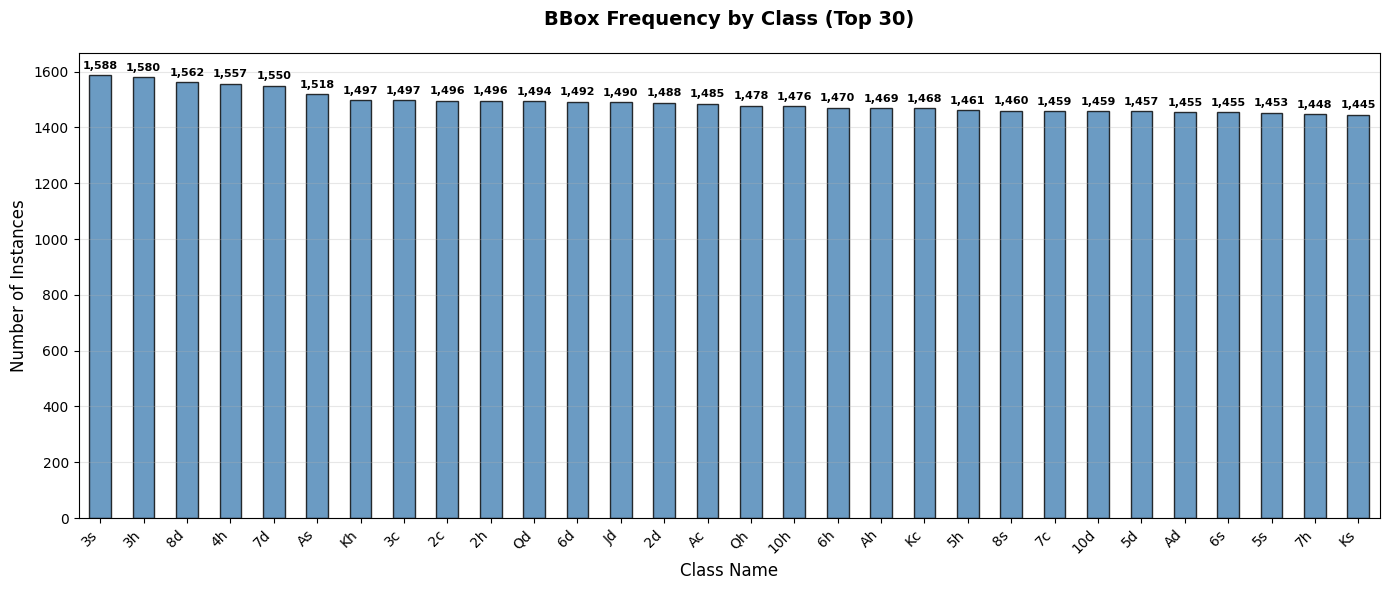

In [4]:

display(HTML("<h2>Preparing BBox Data with Class Information</h2>"))

# Build a detailed DataFrame with all bbox attributes
label_rows = []

for idx, r in df.dropna(subset=['class_name']).iterrows():
    # Extract image dimensions
    W, H = int(r['image_width']), int(r['image_height'])
    
    # Extract class and bbox coordinates
    xc, yc, w, h = r['bbox_x_center'], r['bbox_y_center'], r['bbox_width'], r['bbox_height']
    
    # Compute derived metrics
    area = w * h
    aspect = (w / h) if h > 0 else None
    
    # Append row with complete information
    label_rows.append({
        "image": r['image'],
        "class_name": r['class_name'],
        "xc": xc, "yc": yc, "w": w, "h": h,
        "area": area, "aspect": aspect,
        "img_w": W, "img_h": H,
        "brightness": r['brightness'],
        "contrast": r['contrast']
    })

# Create labels DataFrame
labels_df = pd.DataFrame(label_rows)

print(f"✅ Processed {len(labels_df):,} bounding boxes")
print("\n" + "="*80 + "\n")


display(HTML("<h2>Global Class Statistics</h2>"))

# Count class frequencies
class_counts = labels_df['class_name'].value_counts().sort_values(ascending=False)

# --- Top 5 Most Frequent Classes ---
display(HTML("<h3>Most Frequent Classes (Top 5)</h3>"))

top5 = class_counts.head(5).reset_index()
top5.columns = ['Class_Name', 'Count']

print(tabulate(
    top5[['Class_Name', 'Count']],
    headers=['Class', 'Instances'],
    tablefmt='rounded_outline',
    showindex=False
))


# --- Bottom 5 Least Frequent Classes ---
display(HTML("<h3>Least Frequent Classes (Bottom 5)</h3>"))

bottom5 = class_counts.tail(5).reset_index()
bottom5.columns = ['Class_Name', 'Count']

print(tabulate(
    bottom5[['Class_Name', 'Count']],
    headers=['Class', 'Instances'],
    tablefmt='rounded_outline',
    showindex=False
))


# --- Summary Statistics ---
display(HTML("<h3>Class Distribution Summary</h3>"))

print(f"{'Maximum instances per class:':<40} {class_counts.max():>10,}")
print(f"{'Minimum instances per class:':<40} {class_counts.min():>10,}")
print(f"{'Mean instances per class:':<40} {class_counts.mean():>10,.2f}")
print(f"{'Median instances per class:':<40} {class_counts.median():>10,.1f}")
print(f"{'Total unique classes:':<40} {len(class_counts):>10,}")

print("\n" + "="*80 + "\n")


display(HTML("<h2>Class Frequency Distribution</h2>"))
display(HTML("<h3>Top 30 Most Frequent Classes</h3>"))

# Bar chart: frequency per class (top 30)
plt.figure(figsize=(14, 6))
class_freq = labels_df['class_name'].value_counts().head(30)
class_freq.plot(kind='bar', color='steelblue', edgecolor='black', alpha=0.8)

plt.title('BBox Frequency by Class (Top 30)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(class_freq.values):
    plt.text(i, v + max(class_freq.values)*0.01, f'{v:,}', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()



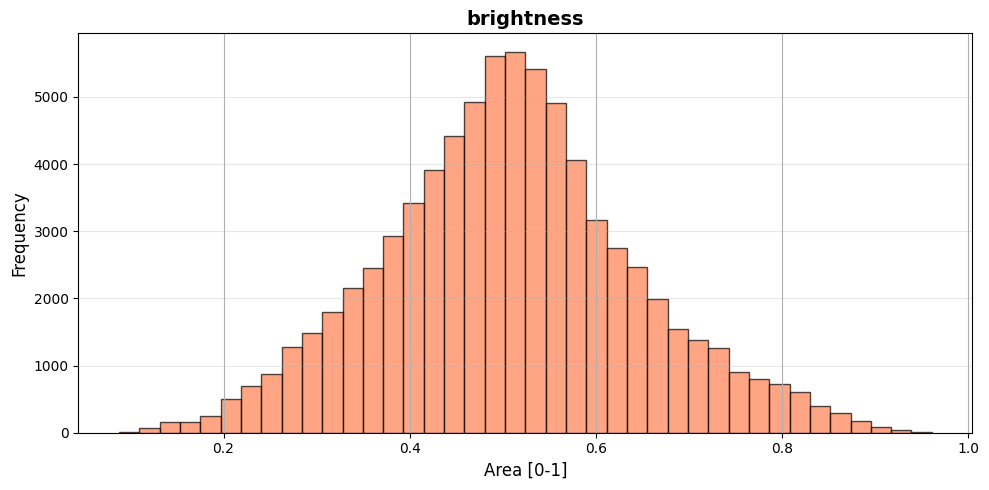

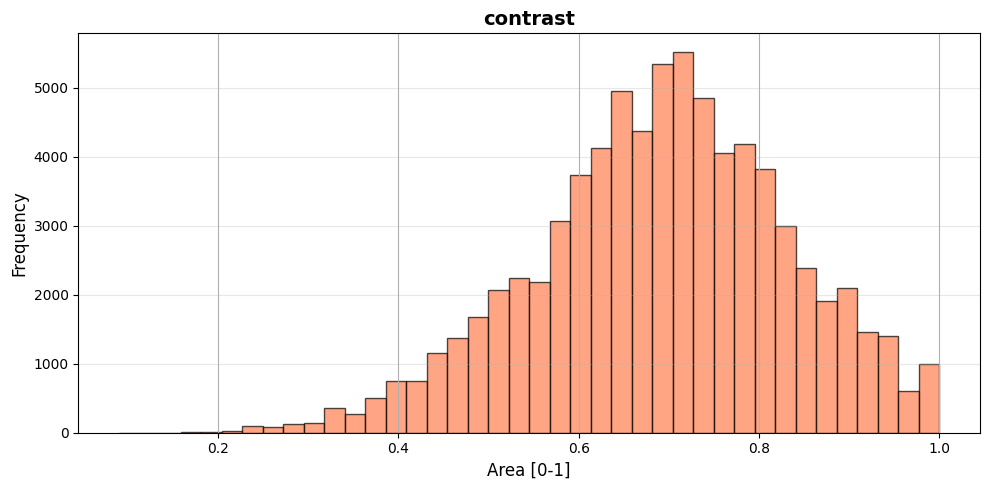

datasets/Playing-Cards-Object-Detection-Dataset/train/images/147381515_jpg.rf.a5ce805d336488b67154d511045a7cde.jpg
datasets/Playing-Cards-Object-Detection-Dataset/valid/images/349250549_jpg.rf.74ea2da58134f73aa9a3d9f4531ca9bd.jpg
datasets/Playing-Cards-Object-Detection-Dataset/train/images/873020013_jpg.rf.b4818103a66109a0dd85699556ad4ee1.jpg


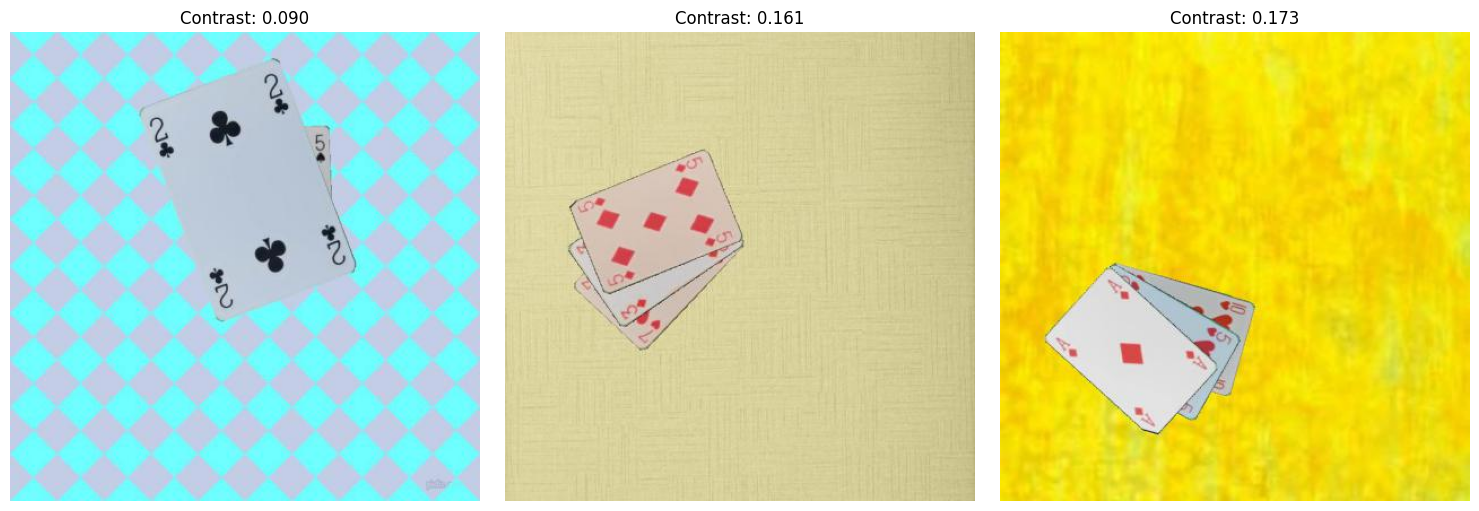

In [5]:
display(HTML("<h2>COLORS</h2>"))
display(HTML("<h3>COLOR</h3>"))


plt.figure(figsize=(10, 5))
labels_df['brightness'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='coral')
plt.title('brightness', fontsize=14, fontweight='bold')
plt.xlabel('Area [0-1]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
labels_df['contrast'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='coral')
plt.title('contrast', fontsize=14, fontweight='bold')
plt.xlabel('Area [0-1]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Ordina per contrasto crescente
lowest_contrast = labels_df.sort_values(by='contrast', ascending=True)

# Mantiene solo righe con path unici
lowest_contrast_unique = lowest_contrast.drop_duplicates(subset='image', keep='first')

# Prende le prime 3 immagini con contrasto più basso
lowest_contrast_unique = lowest_contrast_unique.head(3)

display(HTML("<h3>Immagini con contrasto più basso (percentile 2–98)</h3>"))

plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(lowest_contrast_unique.iterrows()):
    img_path = row['image']
    try:
        img = Image.open(img_path)
        print(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Contrast: {row['contrast']:.3f}")
        plt.axis('off')
    except Exception as e:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, f"Errore:\n{e}", ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.show()

### 2) Classes Distribution Analysis

                       GLOBAL CLASS STATISTICS                        

Most frequent classes (Top 5):

╭─────────┬─────────────╮
│ Class   │   Instances │
├─────────┼─────────────┤
│ 3s      │        1588 │
│ 3h      │        1580 │
│ 8d      │        1562 │
│ 4h      │        1557 │
│ 7d      │        1550 │
╰─────────┴─────────────╯

Least frequent classes (Bottom 5):

╭─────────┬─────────────╮
│ Class   │   Instances │
├─────────┼─────────────┤
│ 9c      │        1398 │
│ 5c      │        1384 │
│ 9d      │        1383 │
│ 3d      │        1366 │
│ Qc      │        1358 │
╰─────────┴─────────────╯

CLASS DISTRIBUTION STATISTICS
----------------------------------------------------------------------
Max instances per class: 1588
Min instances per class: 1358
Mean instances per class: 1456.73
Total unique classes: 52


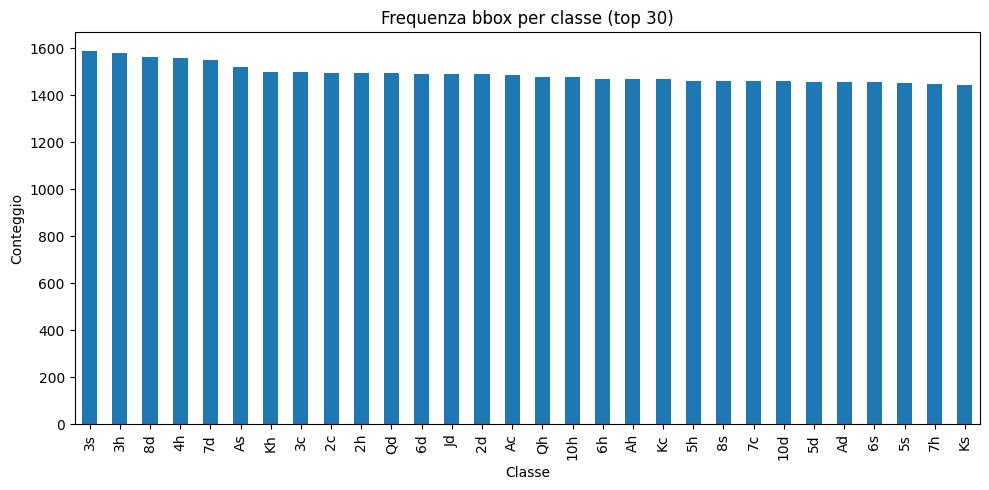

In [6]:
label_rows = []

for idx, r in df.dropna(subset=['class_name']).iterrows():
    W, H = int(r['image_width']), int(r['image_height'])
    xc, yc, w, h = r['bbox_x_center'], r['bbox_y_center'], r['bbox_width'], r['bbox_height']

    area = w * h
    aspect = (w / h) if h > 0 else None

    label_rows.append({
        "image": r['image'],
        "class_name": r['class_name'],
        "xc": xc, "yc": yc, "w": w, "h": h,
        "area": area, "aspect": aspect,
        "img_w": W, "img_h": H
    })

labels_df = pd.DataFrame(label_rows)

# --- Class distribution ---
print("=" * 70)
print("GLOBAL CLASS STATISTICS".center(70))
print("=" * 70)

# Count class frequencies
class_counts = labels_df['class_name'].value_counts().sort_values(ascending=False)

# Top 5 table
top5 = class_counts.head(5).reset_index()
top5.columns = ['Class_Name', 'Count']

# Bottom 5 table
bottom5 = class_counts.tail(5).reset_index()
bottom5.columns = ['Class_Name', 'Count']

# Print top 5
print("\nMost frequent classes (Top 5):\n")
print(tabulate(
    top5[['Class_Name', 'Count']],
    headers=['Class', 'Instances'],
    tablefmt='rounded_outline',
    showindex=False
))

# Print bottom 5
print("\nLeast frequent classes (Bottom 5):\n")
print(tabulate(
    bottom5[['Class_Name', 'Count']],
    headers=['Class', 'Instances'],
    tablefmt='rounded_outline',
    showindex=False
))

# Global stats
print("\nCLASS DISTRIBUTION STATISTICS")
print("-" * 70)
print(f"Max instances per class: {class_counts.max()}")
print(f"Min instances per class: {class_counts.min()}")
print(f"Mean instances per class: {class_counts.mean():.2f}")
print(f"Total unique classes: {len(class_counts)}")
print("=" * 70)

# --- Grafico: frequenza per classe ---
plt.figure(figsize=(10,5))
labels_df['class_name'].value_counts().head(30).plot(kind='bar')
plt.title('Frequenza bbox per classe (top 30)')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 7) Bounding Box Analysis

We check for anomalies in the labels such as:
- bounding boxes with normalized coordinates outside [0,1]
- bounding boxes with zero area (width or height equal to zero)
- images without any bounding boxes

Total bounding boxes:                                  75,750
BBoxes with coordinates outside [0,1]:                      0
BBoxes with near-zero area:                                 0
BBoxes with very large dimensions (w>0.9 or h>0.9):          0
Images without any bbox:                                0.00% (0 / 20,000)




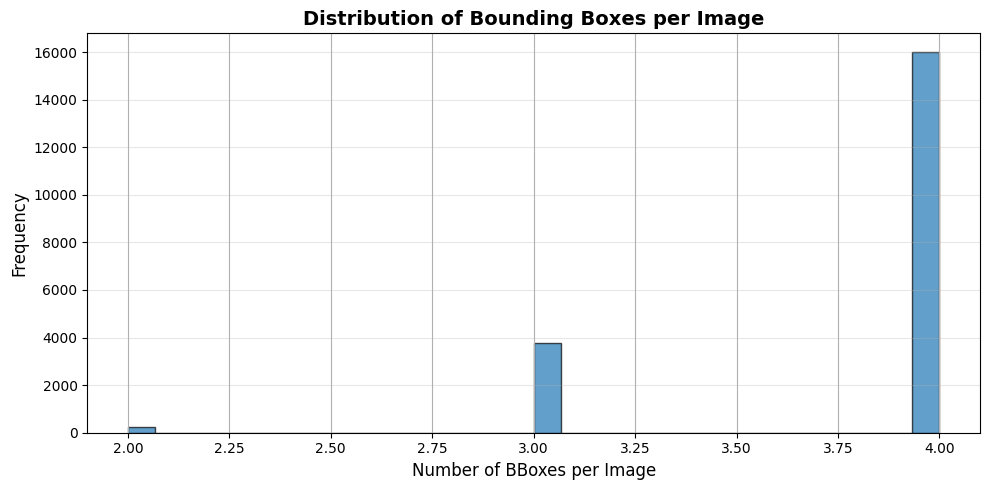

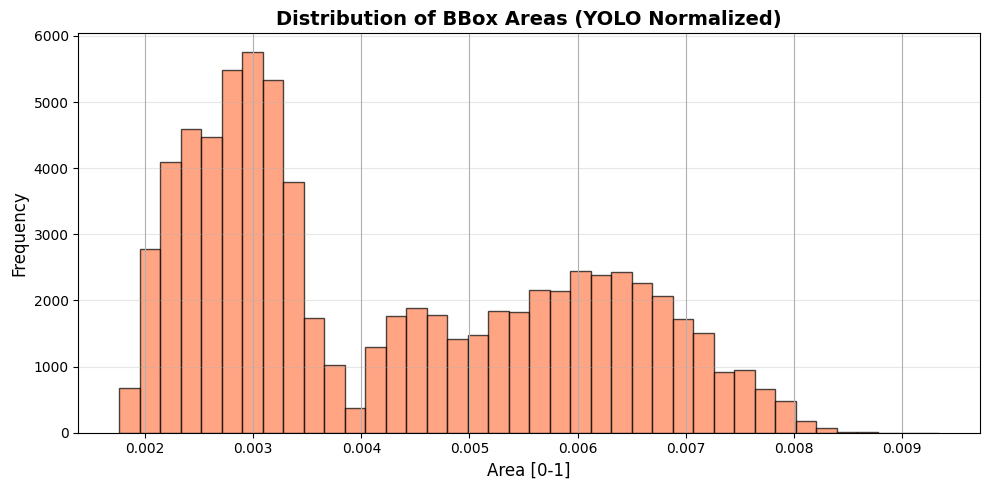

datasets/Playing-Cards-Object-Detection-Dataset/train/images/337030088_jpg.rf.22694ea3ceef10d0796e03a6bd6b84ff.jpg
datasets/Playing-Cards-Object-Detection-Dataset/train/images/862882751_jpg.rf.b54ac5be45cb2b74c3ca0e868e74bdf9.jpg
datasets/Playing-Cards-Object-Detection-Dataset/train/images/979679671_jpg.rf.10d415a617a9f5d0293d78e68ed6be0c.jpg


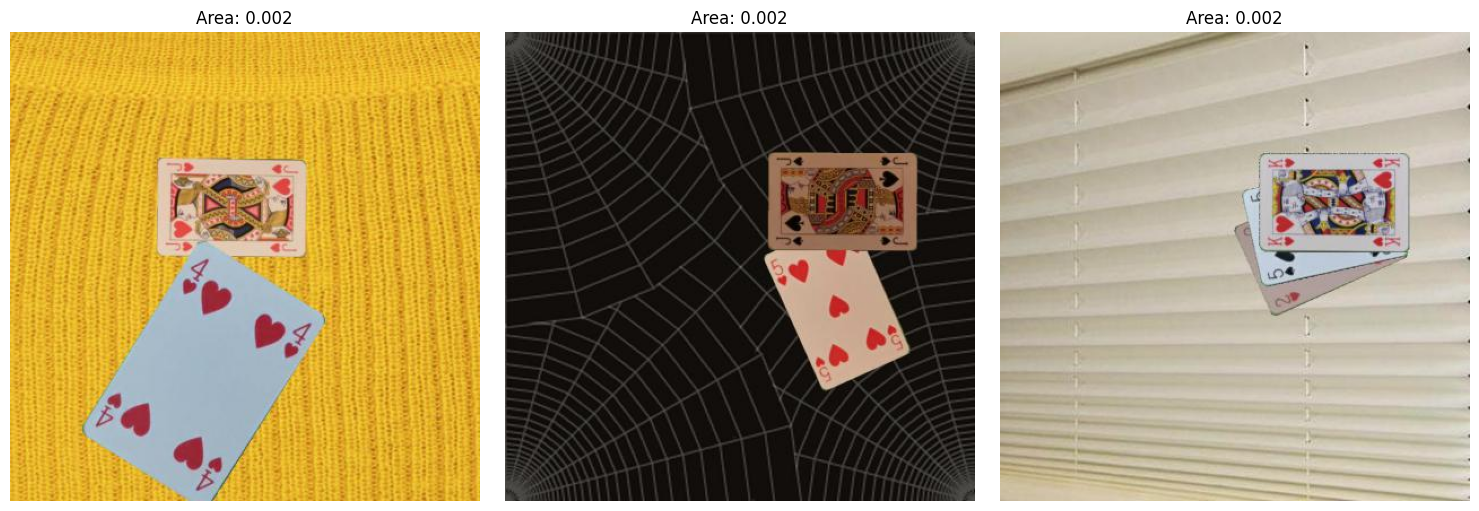

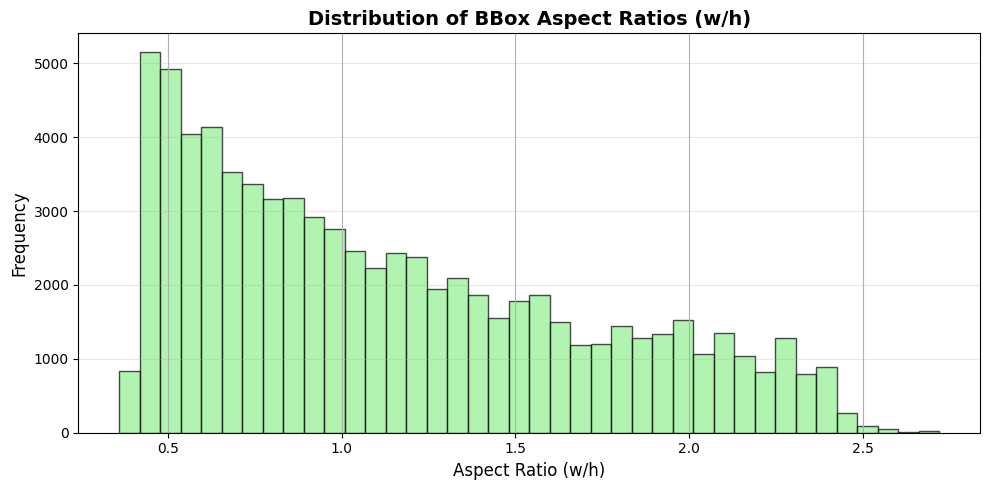

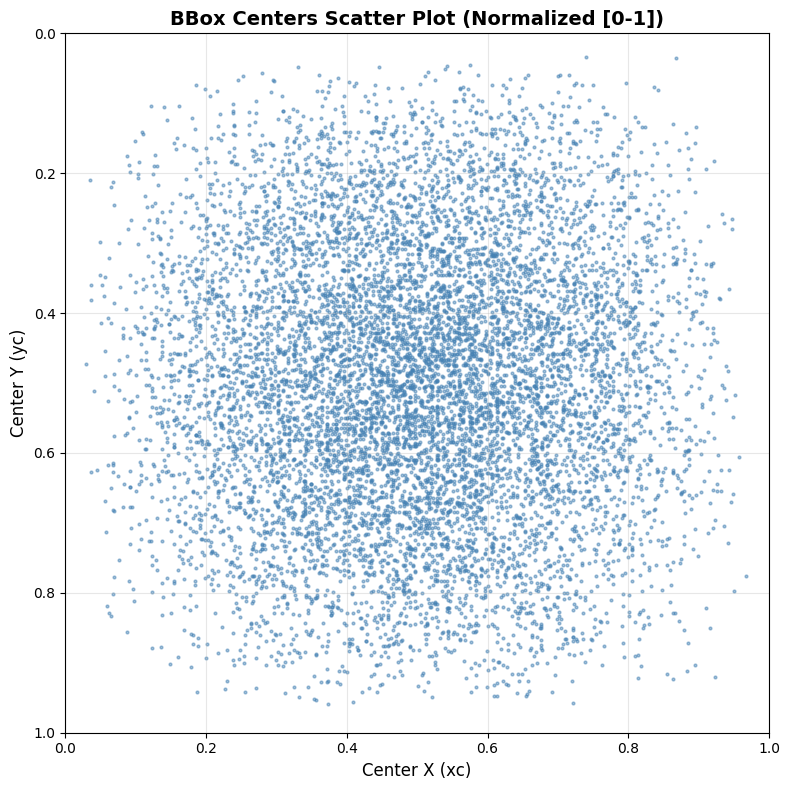

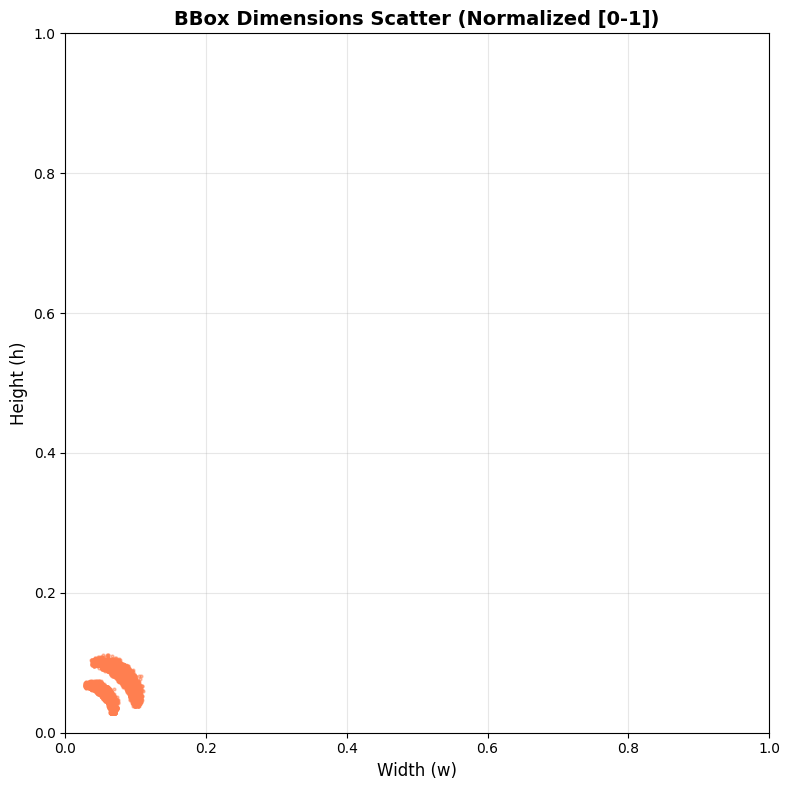

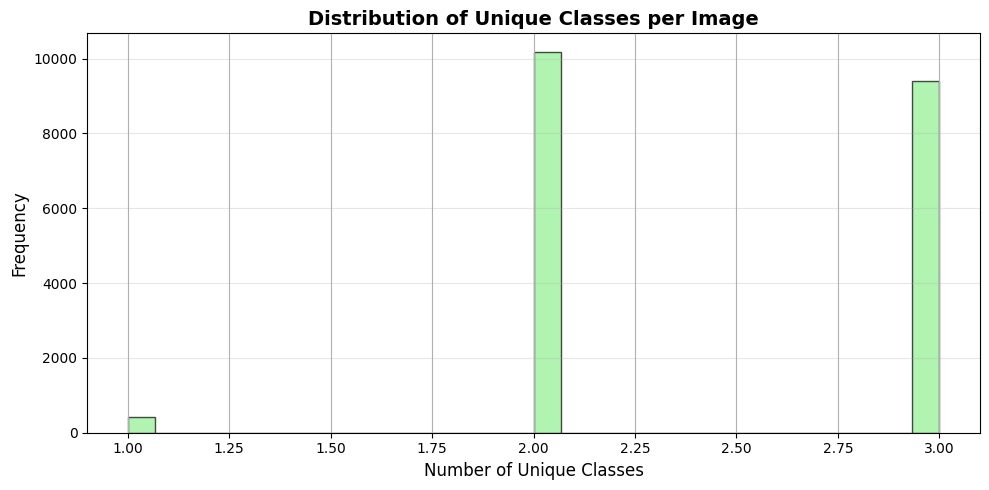

In [7]:
# ============================================================================
# BOUNDING BOX QUALITY ANALYSIS
# ============================================================================

# Display section header
display(HTML("<h2>Bounding Box Quality Metrics</h2>"))

# Total bounding boxes
print(f"{'Total bounding boxes:':<50} {len(labels_df):>10,}")

# Bounding boxes with normalized coordinates outside [0,1]
out_of_bounds = labels_df.query(
    'xc < 0 or xc > 1 or yc < 0 or yc > 1 or w < 0 or w > 1 or h < 0 or h > 1'
).shape[0]
print(f"{'BBoxes with coordinates outside [0,1]:':<50} {out_of_bounds:>10,}")

# Bounding boxes too small or too large
too_small = labels_df.query('w*h < 1e-5').shape[0]
too_big = labels_df.query('w>0.9 or h>0.9').shape[0]
print(f"{'BBoxes with near-zero area:':<50} {too_small:>10,}")
print(f"{'BBoxes with very large dimensions (w>0.9 or h>0.9):':<50} {too_big:>10,}")

# Images without any bounding boxes
all_images = set(df['image'])
labeled_images = set(labels_df['image'])
missing_images = all_images - labeled_images
missing_pct = (len(missing_images) / len(all_images) * 100) if len(all_images) else 0
print(f"{'Images without any bbox:':<50} {missing_pct:>9.2f}% ({len(missing_images):,} / {len(all_images):,})")

print("\n" + "="*80 + "\n")


display(HTML("<h2>Distribution Analysis</h2>"))

# --- Number of bounding boxes per image ---
display(HTML("<h3>BBoxes per Image</h3>"))
bbox_per_image = labels_df.groupby('image').size()

plt.figure(figsize=(10, 5))
bbox_per_image.hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Bounding Boxes per Image', fontsize=14, fontweight='bold')
plt.xlabel('Number of BBoxes per Image', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- BBox area distribution ---
display(HTML("<h3>BBox Area Distribution</h3>"))

plt.figure(figsize=(10, 5))
labels_df['area'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='coral')
plt.title('Distribution of BBox Areas (YOLO Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Area [0-1]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


lowest_area = labels_df.sort_values(by='area', ascending=True)

# Prende le prime 3 immagini a contrasto più basso ma con path diverso
lowest_area = lowest_area.head(3)

display(HTML("<h3>Immagini con contrasto più basso (path unici)</h3>"))

plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(lowest_area.iterrows()):
    img_path = row['image']
    try:
        img = Image.open(img_path)
        print(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Area: {row['area']:.3f}")
        plt.axis('off')
    except Exception as e:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, f"Errore:\n{e}", ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.show()
# --- BBox aspect ratio distribution ---
display(HTML("<h3>BBox Aspect Ratio Distribution</h3>"))

plt.figure(figsize=(10, 5))
labels_df['aspect'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Distribution of BBox Aspect Ratios (w/h)', fontsize=14, fontweight='bold')
plt.xlabel('Aspect Ratio (w/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

display(HTML("<h2> Spatial Distribution</h2>"))

# --- Scatter plot of normalized bbox centers (xc, yc) ---
display(HTML("<h3>BBox Centers Spatial Distribution</h3>"))

if len(labels_df) > 0:
    # Sample to avoid overcrowding
    n = min(10000, len(labels_df))
    sample_centers = labels_df.sample(n, random_state=0)[["xc", "yc"]].dropna()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(sample_centers["xc"], sample_centers["yc"], s=4, alpha=0.5, c='steelblue')
    plt.title("BBox Centers Scatter Plot (Normalized [0-1])", fontsize=14, fontweight='bold')
    plt.xlabel("Center X (xc)", fontsize=12)
    plt.ylabel("Center Y (yc)", fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()  # Origin at top like in images
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No bounding boxes available for visualization.")

# --- Scatter plot of bbox dimensions (w vs h) ---
display(HTML("<h3>BBox Dimensions Distribution (Width vs Height)</h3>"))

if len(labels_df) > 0:
    # Sample to avoid overcrowding
    bb = labels_df[["w", "h"]].dropna()
    n = min(20000, len(bb))
    bb = bb.sample(n, random_state=0)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(bb["w"], bb["h"], s=4, alpha=0.5, c='coral')
    plt.title("BBox Dimensions Scatter (Normalized [0-1])", fontsize=14, fontweight='bold')
    plt.xlabel("Width (w)", fontsize=12)
    plt.ylabel("Height (h)", fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No bounding boxes available for visualization.")


display(HTML("<h2>Class Distribution</h2>"))
display(HTML("<h3>Unique Classes per Image</h3>"))

# Number of unique classes per image
classes_per_image = labels_df.groupby('image')['class_name'].nunique()

plt.figure(figsize=(10, 5))
classes_per_image.hist(bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Distribution of Unique Classes per Image', fontsize=14, fontweight='bold')
plt.xlabel('Number of Unique Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 3) Data Visualization
We visualize a few sample images from each split with their corresponding bounding boxes drawn on them. 

This helps us qualitatively assess the quality of the annotations and get a better understanding of the dataset content.

In [8]:
# ============================================================================
# CLASS CO-OCCURRENCE ANALYSIS
# ============================================================================
display(HTML("<h2>Class Co-occurrence Analysis</h2>"))
display(HTML("<p>Analyzing which classes frequently appear together in the same image</p>"))

# Get unique classes
unique_classes = sorted(labels_df['class_name'].unique())
n_classes = len(unique_classes)

# Initialize co-occurrence matrix
cooccurrence_matrix = np.zeros((n_classes, n_classes), dtype=int)

# Map class_name to matrix index
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

# Count co-occurrences per image
for image in labels_df['image'].unique():
    # All classes present in this image
    classes_in_image = labels_df[labels_df['image'] == image]['class_name'].unique()
    
    # Update symmetric co-occurrence matrix
    for i, cls1 in enumerate(classes_in_image):
        for cls2 in classes_in_image[i:]:
            idx1 = class_to_idx[cls1]
            idx2 = class_to_idx[cls2]
            cooccurrence_matrix[idx1, idx2] += 1
            if idx1 != idx2:
                cooccurrence_matrix[idx2, idx1] += 1

print(f"Co-occurrence matrix computed: {n_classes}x{n_classes} classes")

# ============================================================================
# CO-OCCURRENCE STATISTICS
# ============================================================================

display(HTML("<h3>Co-occurrence Statistics</h3>"))

# Build list of class pairs
cooccurrence_pairs = []
for i in range(n_classes):
    for j in range(i + 1, n_classes):  # upper triangle only
        if cooccurrence_matrix[i, j] > 0:
            cooccurrence_pairs.append({
                'Class_1': unique_classes[i],
                'Class_2': unique_classes[j],
                'Co-occurrences': cooccurrence_matrix[i, j],
            })

if len(cooccurrence_pairs) > 0:
    cooccurrence_df = (
        pd.DataFrame(cooccurrence_pairs)
        .sort_values('Co-occurrences', ascending=False)
        .reset_index(drop=True)
    )

    display(HTML("<h4>Top 15 Most Frequent Class Pairs</h4>"))
    print(tabulate(
        cooccurrence_df.head(15)[['Class_1', 'Class_2', 'Co-occurrences']],
        headers=['Class 1', 'Class 2', 'Co-occurrences'],
        tablefmt='rounded_outline',
        showindex=False
    ))

    if len(cooccurrence_df) > 10:
        display(HTML("<h4>Bottom 10 Rarest Class Pairs (that do co-occur)</h4>"))
        print(tabulate(
            cooccurrence_df.tail(10)[['Class_1', 'Class_2', 'Co-occurrences']],
            headers=['Class 1', 'Class 2', 'Co-occurrences'],
            tablefmt='rounded_outline',
            showindex=False
        ))
else:
    print("No co-occurrences found (no image contains more than one class).")
    cooccurrence_df = pd.DataFrame(columns=['Class_1', 'Class_2', 'Co-occurrences'])

# ============================================================================
# CONDITIONAL PROBABILITY ANALYSIS
# ============================================================================

display(HTML("<h3>Conditional Probabilities</h3>"))
display(HTML("<p>P(Class B | Class A) = When Class A appears, how likely is Class B?</p>"))

# Class frequencies (diagonal)
class_frequencies = np.diag(cooccurrence_matrix)

# Conditional probabilities
conditional_probs = []
for i in range(n_classes):
    if class_frequencies[i] > 0:
        for j in range(n_classes):
            if i != j and cooccurrence_matrix[i, j] > 0:
                prob = cooccurrence_matrix[i, j] / class_frequencies[i]
                conditional_probs.append({
                    'Given_Class': unique_classes[i],
                    'Then_Class': unique_classes[j],
                    'Probability': prob,
                    'Percentage': prob * 100
                })

if conditional_probs:
    conditional_df = pd.DataFrame(conditional_probs).sort_values(
        'Probability', ascending=False
    ).reset_index(drop=True)

    display(HTML("<h4>Top 15 Strongest Conditional Relationships</h4>"))
    print(tabulate(
        conditional_df.head(15)[['Given_Class', 'Then_Class', 'Percentage']],
        headers=['Given Class', 'Then Class', 'P(Then|Given) %'],
        tablefmt='rounded_outline',
        showindex=False,
        floatfmt='.2f'
    ))
else:
    print("No conditional relationships found (each image likely has a single class).")

# ============================================================================
# CO-OCCURRENCE HEATMAP
# ============================================================================

display(HTML("<h3>Co-occurrence Heatmap</h3>"))

top_n = min(20, n_classes)
top_classes_idx = np.argsort(class_frequencies)[-top_n:][::-1]
top_cooccurrence = cooccurrence_matrix[np.ix_(top_classes_idx, top_classes_idx)]
top_class_names = [unique_classes[i] for i in top_classes_idx]

plt.figure(figsize=(14, 12))
sns.heatmap(
    top_cooccurrence,
    xticklabels=top_class_names,
    yticklabels=top_class_names,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Co-occurrences'},
    linewidths=0.5,
    square=True
)
plt.title(f'Class Co-occurrence Matrix (Top {top_n} Classes)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### ?) Draw bounding boxes

In [ ]:
def draw_yolo_boxes_from_df(df, image_path, class_names=None, max_boxes=50):
    """
    Draw YOLO bounding boxes on an image using DataFrame data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing bbox data with columns: image, bbox_x_center, 
        bbox_y_center, bbox_width, bbox_height, class_name
    image_path : str
        Path to the image file
    class_names : list or None
        List of class names for labeling. If None, uses class_name
    max_boxes : int
        Maximum number of boxes to draw (default: 50)
    
    Returns:
    --------
    PIL.Image or None
        Image with drawn bounding boxes, or None if no boxes found
    """
    # Select all boxes for this image (limit to max_boxes)
    boxes = df[df['image'] == image_path].head(max_boxes)
    
    if boxes.empty:
        return None
    
    # Load image and get dimensions
    im = Image.open(image_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)
    
    # Draw each bounding box
    for _, r in boxes.iterrows():
        # Extract YOLO normalized coordinates
        xc, yc, w, h = r['bbox_x_center'], r['bbox_y_center'], r['bbox_width'], r['bbox_height']
        
        # Convert YOLO format (normalized) → absolute pixel coordinates (x1, y1, x2, y2)
        x1 = (xc - w/2) * W
        y1 = (yc - h/2) * H
        x2 = (xc + w/2) * W
        y2 = (yc + h/2) * H
        
        # Draw bounding box rectangle
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        
        # Prepare class label
        # label = str(r['class_name'])
        # if class_names is not None:
        #     if isinstance(class_names, list) and int(r['class_id']) < len(class_names):
        #         label = class_names[int(r['class_id'])]
        #     elif 'class_name' in r:
        #         label = r['class_name']

        # Draw class label
        draw.text((x1 + 2, y1 + 2), r['class_name'], fill="white")
    
    return im


display(HTML("<h2>Sample Images with Annotated Bounding Boxes</h2>"))

# Set random seed for reproducibility
random.seed(0)

# Determine available splits (e.g., train, val, test)
splits = df['split'].unique() if 'split' in df.columns else ['all']

# Extract unique class names for labeling
unique_class_names = df['class_name'].unique().tolist() if 'class_name' in df.columns else None

# Visualize sample images from each split
for split in splits:
    # Filter by split
    subset = df[df['split'] == split] if split != 'all' else df
    unique_images = subset['image'].unique()
    
    # Sample random images (up to 3 per split)
    num_samples = min(3, len(unique_images))
    sample_images = random.sample(list(unique_images), num_samples)
    
    # Draw and display each sampled image
    for img_path in sample_images:
        im = draw_yolo_boxes_from_df(df, img_path, class_names=unique_class_names)
        
        if im is not None:
            plt.figure(figsize=(8, 8))
            plt.imshow(im)
            plt.axis('off')
            
            # Create informative title
            filename = os.path.basename(img_path)
            num_boxes = len(df[df['image'] == img_path])
            title = f"{split.upper()}: {filename}\n({num_boxes} bounding boxes)"
            plt.title(title, fontsize=12, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No bounding boxes found for: {os.path.basename(img_path)}")